## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2023.

## **Task 2: RNN Application -- Tweet Sentiment Analysis** (25%)

In this task, you are going to classify the sentiment of tweets based on whether they are positive or negative using an LSTM model. The code to load the data and see its characteristics has been provided to you. 

In the first task, you will encode the data using one-hot encoding and train an LSTM network to classify the sentiment. In the second task, you will replace the one hot encoding with an embedding layer and train another LSTM model. You will then extract the trained embeddings and visualize the word embeddings in 2 dimensions by using TSNE for dimensionality reduction. 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load Data


In [2]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# Only select the first 1000 test samples for testing
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# Show the text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1 LSTM Encoder (5%)

<font color="red"><strong>TODO:</strong></font> Create and train a single-layer LSTM network to classify tweets.
- Use one-hot encoding to represent each word in the tweet.
- Set LSTM units to 128.
- Use the Adam optimizer and set the batch size to 32.

With these settings, what accuracy do you achieve? You can try to change some parameters in the network to see if you can improve the accuracy. 

<font color="red"><strong>Hint:</strong></font> tf.one_hot and Keras functional API may be useful.
<br>https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from sklearn.model_selection import train_test_split

###################################################
# TODO: Create a single-layer LSTM network.       #
#                                                 #
###################################################
num_words = len(vocabulary)
batch_size = 32

# Split the dataset into training and validation sets
train_tweets, val_tweets, train_labels, val_labels = train_test_split(
    train_tweets, train_labels, test_size=0.1, random_state=42)

def one_hot_batch_generator(data, labels, batch_size, num_words):
    while True:
        for start in range(0, len(data), batch_size):
            end = min(start + batch_size, len(data))
            batch_data = data[start:end]
            batch_labels = labels[start:end]

            # One-hot encode the batch data
            one_hot_data = tf.one_hot(batch_data, depth=num_words)

            # Reshape the one-hot encoded data to 3D shape for LSTM
            one_hot_data = tf.reshape(one_hot_data, (batch_data.shape[0], batch_data.shape[1], num_words))

            yield one_hot_data, batch_labels

 # Create the training and validation generators
train_generator = one_hot_batch_generator(train_tweets, train_labels, batch_size, num_words)
val_generator = one_hot_batch_generator(val_tweets, val_labels, batch_size, num_words)

# Calculate steps per epoch for training and validation
train_steps_per_epoch = len(train_tweets) // batch_size
val_steps = len(val_tweets) // batch_size

# Assuming each tweet has a fixed length after padding
tweet_length = train_tweets.shape[1]

# Create the model
input_layer = Input(shape=(tweet_length, num_words))
lstm_layer = LSTM(128)(input_layer)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator, 
    steps_per_epoch=train_steps_per_epoch, 
    epochs=10, 
    validation_data=val_generator,
    validation_steps=val_steps
)
           
###################################################
# END TODO                                        #
###################################################

Epoch 1/10
1518/1518 [==============================] - 37s 18ms/step - loss: 0.5813 - accuracy: 0.6806 - val_loss: 0.5044 - val_accuracy: 0.7602
Epoch 2/10
1518/1518 [==============================] - 26s 17ms/step - loss: 0.4651 - accuracy: 0.7832 - val_loss: 0.5051 - val_accuracy: 0.7515
Epoch 3/10
1518/1518 [==============================] - 26s 17ms/step - loss: 0.3885 - accuracy: 0.8317 - val_loss: 0.5869 - val_accuracy: 0.7236
Epoch 4/10
1518/1518 [==============================] - 26s 17ms/step - loss: 0.3201 - accuracy: 0.8681 - val_loss: 0.7235 - val_accuracy: 0.7349
Epoch 5/10
1518/1518 [==============================] - 27s 18ms/step - loss: 0.2743 - accuracy: 0.8882 - val_loss: 0.8710 - val_accuracy: 0.7329
Epoch 6/10
1518/1518 [==============================] - 26s 17ms/step - loss: 0.2495 - accuracy: 0.8990 - val_loss: 1.0009 - val_accuracy: 0.7100
Epoch 7/10
1518/1518 [==============================] - 26s 17ms/step - loss: 0.2331 - accuracy: 0.9053 - val_loss: 0.9726 -

## Part 2: Embedding Lookup Layer (15%)

### Define an Embedding Layer

It's not hard to imagine that in the previous practices, the inputs we fed in were very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. A useful technique is *Word Embedding*.

*Word Embedding*: Instead of using a one-hot vector to represent each word, we can add a word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse anymore, because we're working in a continuous vector space now. Words that share similar/related semantic meanings should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness).

<font color="red"><strong>TODO:</strong></font> Define a similar model as above with some improvements.
- Use an Embedding layer instead of one-hot embedding.
- Run the provided training loop.
- Report loss and accuracy for training and validation after each epoch.
- Display the loss value after every 500 steps. 

Do you see any difference in accuracy? What about training time? What inference can you draw?

**Hints**: Refer to the link below.
<br>https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch


In [9]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.callbacks import Callback
###################################################
# TODO: Create a single-layer LSTM network        #
#       using Embedding layer                     #
###################################################
class DisplayLossCallback(Callback):
    def on_batch_end(self, batch, logs=None):
        if batch % 500 == 0:
            print(f"Batch {batch}: Loss = {logs['loss']}")


embedding_dim = 100  # Dimension of the embedding space

input_layer = Input(shape=(None,))
embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_dim)(input_layer)
lstm_layer = LSTM(128)(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_tweets, 
    train_labels, 
    batch_size=32, 
    epochs=10, 
    validation_split=0.1, 
    callbacks=[DisplayLossCallback()]
)

###################################################
# END TODO                                        #
###################################################

Epoch 1/10
1367/1367 [==============================] - 16s 11ms/step - loss: 0.5783 - accuracy: 0.6813 - val_loss: 0.4974 - val_accuracy: 0.7691
Epoch 2/10
1367/1367 [==============================] - 15s 11ms/step - loss: 0.4563 - accuracy: 0.7885 - val_loss: 0.5035 - val_accuracy: 0.7693
Epoch 3/10
1367/1367 [==============================] - 14s 10ms/step - loss: 0.4128 - accuracy: 0.8120 - val_loss: 0.4924 - val_accuracy: 0.7658
Epoch 4/10
1367/1367 [==============================] - 15s 11ms/step - loss: 0.3756 - accuracy: 0.8326 - val_loss: 0.5424 - val_accuracy: 0.7580
Epoch 5/10
1367/1367 [==============================] - 15s 11ms/step - loss: 0.3334 - accuracy: 0.8535 - val_loss: 0.5869 - val_accuracy: 0.7502
Epoch 6/10
1367/1367 [==============================] - 15s 11ms/step - loss: 0.2933 - accuracy: 0.8694 - val_loss: 0.6356 - val_accuracy: 0.7494
Epoch 7/10
1367/1367 [==============================] - 15s 11ms/step - loss: 0.2691 - accuracy: 0.8783 - val_loss: 0.7639 -

Run the following cells to train your model

In [10]:
from tensorflow import keras
train_dataset = tf.data.Dataset.from_tensor_slices((train_tweets, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((test_tweets, test_labels))
test_dataset = test_dataset.batch(batch_size)

train_acc_metric = keras.metrics.BinaryAccuracy() 
val_acc_metric = keras.metrics.BinaryAccuracy() 

train_loss_metric = keras.metrics.BinaryCrossentropy()
val_loss_metric = keras.metrics.BinaryCrossentropy()

In [11]:
# Training Loop

import time
optimizer = keras.optimizers.Adam() 
# Instantiate a loss function.
loss_fn = keras.losses.BinaryCrossentropy()  


epochs = 1
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    epoch_loss= 0
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        train_loss_metric.update_state(y_batch_train, logits)

        epoch_loss+= float(loss_value)
        # Log every 500 batches.
        
        if step % 500 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
        
      
    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    train_loss = train_loss_metric.result()
    print("Training loss over epoch: %.4f" % (float(train_loss),))
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()
    train_loss_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in test_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
        val_loss_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_loss = val_loss_metric.result()
    val_loss_metric.reset_states()

    print("Validation loss: %.4f" % (float(val_loss),))
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.2088
Seen so far: 32 samples
Training loss (for one batch) at step 500: 0.1810
Seen so far: 16032 samples
Training loss (for one batch) at step 1000: 0.2012
Seen so far: 32032 samples
Training loss (for one batch) at step 1500: 0.4805
Seen so far: 48032 samples
Training loss over epoch: 0.2220
Training acc over epoch: 0.9013
Validation loss: 0.5486
Validation acc: 0.7500
Time taken: 39.29s


## Part 3: Visualize Word Vectors via t-SNE (5%)

<font color="red"><strong>TODO:</strong></font>
- First, you need to retrieve the embedding matrix from the network.
- Then use t-SNE to reduce each low-dimensional word vector into a 2D vector.
- Then, you should visualize some interesting word pairs in 2D panel. (You may find scatter function in matplotlib.pyplot useful.)

<font color="red"><strong>Hint:</strong></font> You can use the t-SNE tool provided in scikit-learn, and if you encounter a dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., conda install nomkl numpy scipy scikit-learn numexpr.

Here we provide some word pairs for you like indoor-outdoor activities and you can observe that these word-pair will look parallel with each other in a 2D t-SNE panel. You can find some other words and explore their relationship.

In [12]:
!pip install scikit-learn

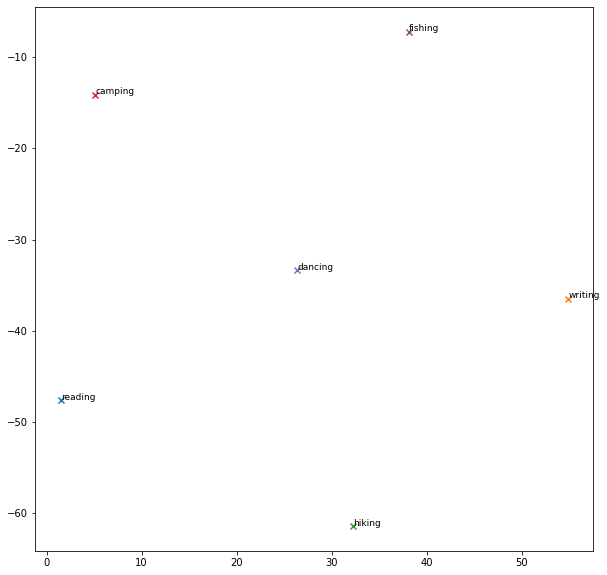

In [22]:
# Word pairs provided
indoor_outdoor = ['reading', 'writing', 'hiking', 'camping']
# You may try some other words as well

###################################################
# TODO: Visualize word vectors using TSNE.        #
#                                                 #
###################################################
# Create a word-to-index mapping dictionary if 'vocabulary' represents words
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

# Proceed with t-SNE visualization using the newly created mapping
words = ['reading', 'writing', 'hiking', 'camping', 'dancing', 'fishing']
word_indices = [word_to_index[word] for word in words if word in word_to_index]

# Select the corresponding vectors from the embedding matrix
selected_word_vectors = embedding_matrix[word_indices]

# Use t-SNE for Dimensionality Reduction
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(selected_word_vectors)

# Visualize with Matplotlib
plt.figure(figsize=(10, 10))
for word, coord in zip(words, word_vectors_2d):
    x, y = coord
    plt.scatter(x, y, marker='x')
    plt.text(x + 0.05, y + 0.05, word, fontsize=9)
plt.show()


###################################################
# END TODO                                        #
###################################################

<font color="red"><strong>Note:</strong></font> Install **sklearn** if you haven't already. 

```
> pip install scikit-learn
```